In [55]:
import os
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchmetrics import Accuracy, ConfusionMatrix
from tqdm.auto import tqdm
import random
from mlxtend.plotting import plot_confusion_matrix

In [56]:
# load dataset
file = "./my_dataset/FashionMNIST/"
if os.path.exists(file):
    download_file = False
else:
    download_file = True

train_data = datasets.FashionMNIST(root="./my_dataset/", train=True, download=download_file,
                                   transform=ToTensor(), target_transform=None)
test_data = datasets.FashionMNIST(root="./my_dataset/", train=False, download=download_file,
                                  transform=ToTensor(), target_transform=None)

class_names = train_data.classes

print(f"Length train data: {len(train_data)}")
print(f"Length test data: {len(test_data)}")
print(f"N° class: {len(class_names)}")
print(f"Names class: {class_names}")

Length train data: 60000
Length test data: 10000
N° class: 10
Names class: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Image shape: torch.Size([1, 28, 28])
Image label: Ankle boot


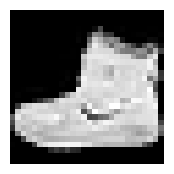

In [57]:
# plot image
image, label = train_data[0]
print(f"Image shape: {image.shape}")
print(f"Image label: {class_names[label]}")
plt.figure(figsize=(3,2))
plt.imshow(image.squeeze(), cmap="gray")
plt.axis(False);

In [58]:
# prepare Dataloader
dev = "cuda" if torch.cuda.is_available() else "cpu"

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

In [59]:
# build model
class FashionMNISTModel(nn.Module):
    def __init__(self, input_shape, output_shape, hidden_units) :
        super().__init__()
        
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels= hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels= hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        self.block_3 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
            )
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        # print(f"Output shape of block 2: {x.shape}") # para saber el 7*7
        x = self.block_3(x)
        return x

# 1 por channel es gray, si fuera a color seria 3
model_0 = FashionMNISTModel(input_shape=1, output_shape=len(class_names), hidden_units=10).to(dev)
model_0

FashionMNISTModel(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [60]:
# loss, optimizer, accuracy
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
acc_fn = Accuracy("multiclass", num_classes=len(class_names)).to(dev)

In [61]:
# train step
def train_step(model:nn.Module, data_loader: DataLoader, loss_fn: nn.Module, 
               optimizer: torch.optim.Optimizer, acc_fn,dev:torch.device=dev):
    
    train_loss, train_acc= 0,0
    model.to(dev)
    for batch, (x,y) in enumerate(data_loader):

        x,y = x.to(dev), y.to(dev)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += acc_fn(y, y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= len(data_loader)
    train_acc  /= len(data_loader)

    print(f"Train loss: {train_loss:.3f} | Train acc: {train_acc:.3f}%")

# test step 
def test_step(model:nn.Module, data_loader:DataLoader, loss_fn:nn.Module,
              optimizer:torch.optim.Optimizer, acc_fn, dev:torch.device=dev):
    
    test_loss, test_acc = 0,0
    model.to(dev)
    model.eval()
    with torch.inference_mode():
        for x,y in data_loader:

            x,y = x.to(dev), y.to(dev)
            test_pred = model(x)
            test_loss += loss_fn(test_pred, y)
            test_acc += acc_fn(y, test_pred.argmax(dim=1))
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.3f} | Test acc: {test_acc:.3f}%")   

In [62]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 3

for epoch in tqdm(range(epochs)):
    
    print(f"Epoch: {epoch}\n---------")
    
    train_step(model=model_0, data_loader=train_dataloader, loss_fn=loss_fn,
               optimizer=optimizer, acc_fn=acc_fn, dev=dev)
    
    test_step(model=model_0, data_loader=test_dataloader, loss_fn=loss_fn,
              optimizer=optimizer, acc_fn=acc_fn, dev=dev)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.746 | Train acc: 0.729%


 33%|███▎      | 1/3 [00:04<00:09,  4.59s/it]

Test loss: 0.391 | Test acc: 0.861%
Epoch: 1
---------
Train loss: 0.368 | Train acc: 0.867%


 67%|██████▋   | 2/3 [00:09<00:04,  4.58s/it]

Test loss: 0.367 | Test acc: 0.865%
Epoch: 2
---------
Train loss: 0.332 | Train acc: 0.880%


100%|██████████| 3/3 [00:13<00:00,  4.59s/it]

Test loss: 0.354 | Test acc: 0.873%


In [63]:
# Get Results in Dictionary for model test
torch.manual_seed(42)
def eval_model(model:nn.Module, data_loader: DataLoader, loss_fn:nn.Module, 
               acc_fn, dev:torch.device=dev):
    conf_matrix = []
    test_loss, test_acc = 0,0
    model.eval()
    with torch.inference_mode():
        for x,y in data_loader:
            
            x,y = x.to(dev), y.to(dev)
            test_pred = model(x)
            test_loss += loss_fn(test_pred, y)
            test_acc += acc_fn(y, test_pred.argmax(dim=1))
            
            matrix = torch.softmax(test_pred, dim=1).argmax(dim=1)
            conf_matrix.append(matrix.cpu())

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    
    return {"model_name": model.__class__.__name__, "model_loss": test_loss.item(),
            "model_acc": test_acc, "conf_matrix":torch.cat(conf_matrix)}
model_0_results = eval_model(model=model_0, data_loader=test_dataloader, loss_fn=loss_fn,
                             acc_fn=acc_fn, dev=dev)
model_0_results

{'model_name': 'FashionMNISTModel',
 'model_loss': 0.3544442355632782,
 'model_acc': tensor(0.8725, device='cuda:0'),
 'conf_matrix': tensor([9, 2, 1,  ..., 8, 1, 5])}

In [64]:
# Make and evaluate random predictions with best model
def make_predictions(model: nn.Module, data:list, dev:torch.device=dev):
    pred_probs = []
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(dev)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(),dim=0)
            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

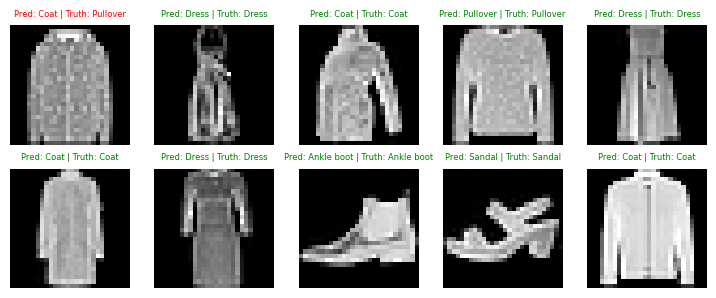

In [65]:
# Create test sample random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=10):
    test_samples.append(sample)
    test_labels.append(label)

pred_probs= make_predictions(model=model_0, data=test_samples)
pred_classes = pred_probs.argmax(dim=1)

# plot images
plt.figure(figsize=(9, 9))
nrows = 5
ncols = 5
for i, sample in enumerate(test_samples):
  
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")
  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_labels[i]] 
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  if pred_label == truth_label:
      plt.title(title_text, fontsize=6, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=6, c="r") # red text if wrong
  plt.axis(False);

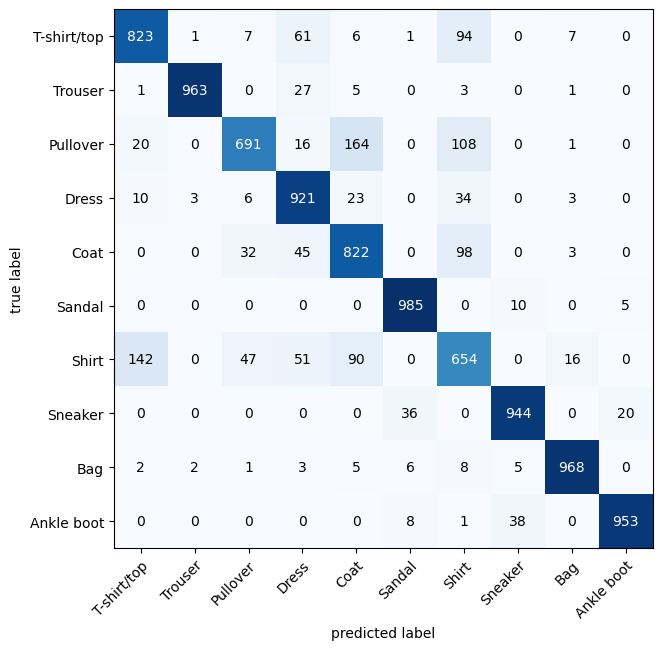

In [67]:
# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=model_0_results["conf_matrix"],
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7) );